In [7]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import pylab
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
from random import shuffle         # For shuffling start position list
from kernels import fac_kernel    # Factory Method which yields Kernel Object

import cPickle as pickle
import time
import scipy.optimize as opt

ImportError: No module named kernels

Dim. of X-data: 400 x 2
Mean p: 
[ 0.3925  0.7275  0.235   0.6575  0.2575  0.5725  0.4775  0.54    0.6025
  0.6775  0.71    0.7     0.655   0.59    0.64    0.8075  0.8075  0.5225
  0.525   0.7275  0.4925  0.6075  0.62    0.595   0.6625  0.5625  0.8625
  0.615   0.6475  0.51    0.6625  0.675   0.5875  0.595   0.52    0.61
  0.6125  0.1925  0.6775  0.47    0.635   0.5075  0.6     0.46    0.6125
  0.65    0.51    0.49    0.485   0.5325  0.56    0.71    0.5875  0.595
  0.45    0.26    0.5675  0.6125  0.555   0.65    0.575   0.5625  0.505
  0.865   0.555   0.715   0.6475  0.64    0.4175  0.56    0.58    0.5975
  0.3     0.435   0.5225  0.5675  0.7325  0.6675  0.5175  0.6725  0.5425
  0.5625  0.65    0.4025  0.7125  0.305   0.5625  0.6225  0.2125  0.3875
  0.585   0.5825  0.4675  0.6175  0.415   0.785   0.535   0.6825  0.5475
  0.45  ]
Dim. of Y-data: 400 x 100
Assumed f-mean:
[ 1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.570

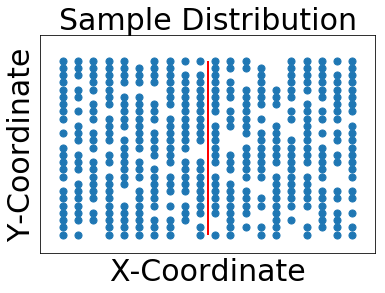

In [3]:
nr_inds = 400 # Nr. of Individuals to Check

X_data = np.loadtxt('./coordinates15.csv', delimiter='$').astype('float64') # Load the complete X-Data
Y_data = np.loadtxt('./data_genotypes15.csv', delimiter='$').astype('float64') # Load the complete Y-Data

#path1 = "data_lists.p"  # Load data from pickle file!
#x_data_sets, y_data_sets  = pickle.load(open(path1, "rb"))  # Load data from pickle file!
#print("Length of Data-Set: ")
#print(len(x_data_sets))
#data_set_nr=1
#X_data=x_data_sets[data_set_nr]
#Y_data=y_data_sets[data_set_nr]

#print(len(X_data))
inds=range(len(X_data))
shuffle(inds)  # Random permutation of the indices. If not random draw - comment out
inds=inds[:nr_inds]  # Only load first nr_inds


# Only load first nr_inds entries
X_data = X_data[inds,:]
Y_data = Y_data[inds,:]

#./data_genotypes5.csv has mean p=0.2
assert(len(X_data) == len(Y_data))

N = X_data.shape[0]
k = X_data.shape[1]
print("Dim. of X-data: %i x %i" % (N,k))
M1 = Y_data.shape[0]
nr_loci = Y_data.shape[1]


p_mean = np.mean(Y_data, axis=0) # Empirical average for every loci
#p_mean=np.mean(Y_data)
print("Mean p: ")
print(p_mean)

# Change this for coordinates5.csv  (If mean is known)
#f_mean = np.loadtxt('./mean_f6.csv', delimiter='$').astype('float64')[inds]   # Empirical f_mean
#f_mean = np.log(p_mean) - np.log(1 - p_mean) # Does a Logit Transform
#f_mean=np.log(0.2)-np.log(1.0-0.2)   # If known

#print(len(f_mean))
#print(len(f_mean))
Y_data[Y_data < 0.5] = -1.0  # For the logit Link function
print("Dim. of Y-data: %i x %i" % (M1, nr_loci))

#mean_paramss = np.array([f_mean for _ in range(nr_loci)]) # Initial Parameter for the mean-parameters
#mean_paramss = np.array([0.0 for _ in range(nr_loci)])  # Set everything to 0
mean_paramss = np.array([np.pi/2.0 for _ in range(nr_loci)])  # Set everything to 0.5. For ArcSin Model
#mean_paramss = np.array(f_mean)
print("Assumed f-mean:")
print(mean_paramss[:10])

# Plot the data
pylab.figure()
pylab.title("Sample Distribution", fontsize=30)
pylab.scatter(X_data[:,0], X_data[:,1], label = "Samples",s=50)
pylab.vlines(0, min(X_data[:,1]), max(X_data[:,1]), linewidth=2, color="red", label="Barrier")
pylab.xlabel("X-Coordinate", fontsize=30)
pylab.ylabel("Y-Coordinate", fontsize=30)
pylab.xlim([-22,22])
pylab.ylim([-30,30])
pylab.tick_params(axis='both', which='both', bottom='off', 
                    top='off', labelbottom='off', right='off', left='off', labelleft='off')
#pylab.legend(fontsize=20)
pylab.show()

In [5]:
###### The Full Kernel:
def full_kernel_function(coords, l, a, c, sigma_sqrd=0):
    '''Return barrier Kernel - describing reduced correlation across barrier
    and increased correlation next to barrier. Coords is nx2 Numpy array.
    Barrier is assumed to be at x=0'''
    x = coords[:, 0]  # Extracts x-coords
    nr_inds=tf.size(x)
    
    mask = tf.constant([-1.0, 1.0], dtype=tf.float64) # Mask used for reflecting coordinates
    
    coords_refl = coords * mask[None,:]  # Reflects the x-Coordinate
    
    g = tf.sign(x)  # Calculates Signum of x
    same_side = (g[:,None] * g + 1) / 2  # Whether the x-Values are on the same side
    #print("Same Side Vector: ")
    #print(same_side)
    
    r_sqrd = tf.reduce_sum(((coords[:, None] - coords[None, :]) ** 2), reduction_indices=[2])  # Calculates pairwise Distance
    r_refl_sqrd = tf.reduce_sum(((coords_refl[:, None] - coords[None, :]) ** 2), reduction_indices=[2])  # Calculates the reflected Distance 
    
    # Calculate the normal Kernel:
    cov_mat = a * tf.exp(-r_sqrd / (2. * l ** 2))  # Calculate the co-variance matrix. Added diagonal term
    cov_mat_refl = a * tf.exp(-r_refl_sqrd / (2. * l ** 2))  # Calculate the covariance matrix for reflected coordinates.
    
    # Introduce the Covariance Function due to complete correlation
    K1 = sigma_sqrd * tf.ones((nr_inds,nr_inds),dtype=tf.float64)
    
    # Calculate the full Covariance Matrix
    K = same_side * (cov_mat + c * cov_mat_refl) + (1 - same_side) * (1 - c) * cov_mat + K1
    
    #print("Covariance Matrix: ")
    #print(cov_tot)
    #print("Eigenvalues: ")
    #print(np.linalg.eig(cov_mat)[0])
    return K

def rbf_kernel_function(coords, l, a):
    '''The usual exponential kernel function'''
    K = a * tf.exp(-tf.reduce_sum(((coords[:, None] - coords[None, :]) ** 2) / (2 * l**2), reduction_indices=[2]))
    return K

In [6]:
# From Alex: To calculate the log determinant

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))
    
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def py_logdet(x, name=None):
    
    with ops.op_scope([x], name, "Logdet") as name:
        logdet = py_func(lambda x: np.linalg.slogdet(x)[1],
                         [x],
                         [tf.float64],
                         name=name,
                         grad=_LogdetGrad)  # <-- here's the call to the gradient
    return logdet[0]

def _LogdetGrad(op, grad):
    x = op.inputs[0]
    return tf.matrix_inverse(x) * grad[:, None, None]

In [7]:
# For sin^2(x/2) Link function
def link_f(f):   # Define Link function
    '''Sinus Squared Link function'''
    pi=0.999*np.pi*tf.ones((N, nr_loci), dtype=tf.float64)  # Matrix - for values bigger than Pi. 
    #Allow for values slightly smaller than Pi to infinte likelihood (to avoid infinities)
    z=0.001*tf.ones((N, nr_loci), dtype=tf.float64)       
    # Matrix - for values smaller than 0. Allow for small values slightly bigger than 1 (to avoid infinities)
    f=tf.where(f>np.pi, pi, f)       # Make values bigger than pi almost pi
    f=tf.where(f<0, z, f)            # Make values smaller than 0 almost 0
    
    y = tf.sin(0.5*f) ** 2        # Do the actual calculation
    return y

with tf.device('/gpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value = X_data, trainable=False)
    Y = tf.Variable(dtype=tf.float64, initial_value = Y_data, trainable=False)
    F = tf.Variable(dtype=tf.float64, initial_value = np.random.normal(0.0, 0.1, (N, nr_loci)).astype('float64'),
                    trainable=True)

    #hyper_params = tf.placeholder(shape = [3 + nr_loci], dtype=tf.float64)      # HyperParameters for the Kernel
    hyper_params = tf.placeholder(shape=[4], dtype = tf.float64)                # The Kernel Hyper Parameters
    hyper_params_means =tf.placeholder(shape=[nr_loci], dtype = tf.float64)      # The Mean Hyper Parameters
    
    # First two are for the kernel; nr_loci are for the means of the GRFs!
    #mean_params = tf.placeholder(shape=[nr_loci], dtype=tf.float64)  # HyperParameters for the mean Values
    
    # Take Absolute Values - to avoid problems for negative values
    a = tf.abs(hyper_params[0])           # The Parameter for the absolute correlation
    l = tf.abs(hyper_params[1])           # The Parameter for the length scale
    c = tf.abs(hyper_params[2])           # The Parameter for the Barrier strenght
    sigma_sqrd = tf.abs(hyper_params[3])  # The Parameter for the overall deviation from the mean (Gaussian Model)
    
    #mean_param = hyper_params[3:]   # The mean parameters
    mean_param = hyper_params_means
    
    eye = tf.eye(N, dtype=tf.float64)

    # The Kernel for the classical Covariance Matrix
    #K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l**2), reduction_indices=[2])) + 0.00001*eye\
    #0.00001 * tf.eye(N, dtype=tf.float64) # Calculate Matrix of Covariances
    
    # The Kernel for the full covariance Matrix:
    K = full_kernel_function(X, l, a, c, sigma_sqrd) + 0.00001 * eye # Add identity to make positive definite
    #K = rbf_kernel_function(X, l, a) + 0.00001 * eye  # Add identity to make positive definite
 
    
    f_tot = F + mean_param[None, :]    # Adds mean term; None is at position of an individual
    #f_tot= F + f_mean[None,:]          # Adds empirical mean term
    #f_tot = F + f_mean                 # For the case that there is a single Value
    p = link_f(f_tot)    # Calculate novel p, assuming sin^2 Link Function
    Kinv_F = tf.matrix_solve(K, F)      # Calculate K^(-1)*F
    
    g0 = tf.greater(Y, 0.5)        # Values where Y is greater than 0; i.e. data is 1.
    g0 = tf.cast(g0, tf.float64)   # Transform so that can be multiplied

    y_f= g0*p + (1-g0)*(1-p)  # Probability of observing y given probabilities p
    
    data_fit = tf.reduce_sum(tf.log(y_f), reduction_indices=[0])   # Calculate Data Fit: Check  
    prior_fit = -0.5 * tf.reduce_sum(F * Kinv_F, reduction_indices=[0])          # Calculate 1st term of prior probability: Check
    
    logL = tf.reduce_sum(data_fit + prior_fit) # Modulo terms not depending on f: Check
    
    d1 = 1.0/tf.tan(0.5*f_tot)   # Gradient coming from f_tot (for y=1)
    d0 = -tf.tan(0.5*f_tot)      # Gradient comfing from t_tot (for y=0)
    
    grad1 = g0*d1 + (1-g0)*d0  # First part of the gradient
    
    g =  grad1 - Kinv_F       # Calculate Matrix for Gradients Check
    
    h1 = -0.5 / ((tf.sin(0.5 * f_tot))**2) # Minus second derivative of data. (for y=1)
    h0 = -1.0 / (1 + tf.cos(f_tot))        # Second derivative of data (for y=0)
    W = - g0 * h1 - (1 - g0) * h0       # Calculate first part of Hessian. It is diagonal (but here diagonal in every column)
    
    lhs = -K[:, :, None] * W[None, :, :] - tf.eye(N, dtype=tf.float64)[:, :, None] # Check (HEAD-ACHE)
    #lhs = -K[:, :, None] * W[None, :, :] - eye[:, :, None] 
    rhs = tf.matmul(K, g)
    
    update = tf.matrix_solve(tf.transpose(lhs, [2, 0, 1]), tf.transpose(rhs, [1, 0])[:, :, None])[:, :, 0]
    update = tf.transpose(update)
    
    opt_op = F.assign(F - update)
    
    #####
    
    B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + tf.eye(N, dtype=tf.float64)[:, :, None]  # Check
    #B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + eye[:, :, None] 
    
    logdet = tf.reduce_sum(py_logdet(tf.transpose(B, [2, 0, 1])))  # Factor of 2??
    
    margL = logL - 0.5 * logdet
    
    ##### Gradients and Hessian #######################3
    
    grad = tf.gradients(margL, hyper_params)
    hessian = tf.hessians(margL, hyper_params)  # Comment out to avoid computational overhead.

In [8]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.allow_soft_placement = True

In [9]:
opt.fmin_l_bfgs_b?

In [11]:
### Optimization Run with BFGS
#hyper_paramss = np.array([0.02, 15, 0.2]) # The initial values for a & L & c // 0.02 25 0.8
mps = mean_paramss
initial_values = np.array([0.015, 10, 0.4, 0.08]) # Optimize with the right initial Values

#kk =  np.array([0.012, 20] + f)

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
        
    for _ in range(5):   # First optimize the f locally with the initial Values
        _, = sess.run([opt_op], {hyper_params: initial_values, hyper_params_means: mps})  

    def fg(x):
        print("\nInside Function \n")
        print(x)
        
        for _ in range(5):   # Optimize the f locally
            _, = sess.run([opt_op], {hyper_params: x, hyper_params_means: mps}) # Optimize for right Hyper_params
        f, g = sess.run([margL, grad], {hyper_params: x, hyper_params_means: mps})
        print("Likelihood: ")
        print(f)
        return -f, -g[0]

    result = opt.fmin_l_bfgs_b(fg, initial_values, disp=0,
                               bounds=[(0.0001, 1), (0.01, 100), (0, 1), (0,1)])
    hyper_paramss = result[0]

    print(['%.4f %.2f %.2f %.4f' % (hyper_paramss[0], hyper_paramss[1], hyper_paramss[2], hyper_paramss[3])])
    
# Code for calculating empirical Fisher-Information Matrix:
fisher_info = np.matrix(h[0])
stds = np.sqrt(np.diag(-fisher_info.I)) # Calculates the Standard Deviations (Sqrt of Variance)
print("Standard Deviations: ")
print(stds)


Inside Function 

[  0.015  10.      0.4     0.08 ]
Likelihood: 
-25121.1217082

Inside Function 

[  1.          52.49681794   1.           1.        ]
Likelihood: 
-24634.8628968

Inside Function 

[  0.9874329   51.33312872   0.97505558   0.97427165]
Likelihood: 
-24617.097875

Inside Function 

[  0.93716448  46.67837184   0.87527792   0.87135825]
Likelihood: 
-24552.6487167

Inside Function 

[ 0.37941793  0.01        0.09862027  0.        ]
Likelihood: 
-27286.9530731

Inside Function 

[  0.92059095  45.29161288   0.8521994    0.84546568]
Likelihood: 
-24535.7551569

Inside Function 

[  0.65000444  22.65080644   0.47540983   0.42273284]
Likelihood: 
-24287.0448133

Inside Function 

[ 0.0001  0.01    0.      0.    ]
Likelihood: 
-27725.8871015

Inside Function 

[  0.64331521  22.4177729    0.47051661   0.41838181]
Likelihood: 
-24284.7056438

Inside Function 

[  0.3217076   11.21388645   0.23525831   0.2091909 ]
Likelihood: 
-24274.8448194

Inside Function 

[  0.52781064  1

In [10]:
### Optimization with Nelder-Mead
mps = mean_paramss
initial_values = [0.015, 20, 0.4, 0.02]

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    for j in range(5):
        _ = sess.run([opt_op], {hyper_params: initial_values, hyper_params_means: mps}) 
    
        
    def f(x):
        print("\nParameters: ")
        print(x)
        
        for i in range(2):
            _, = sess.run([opt_op,], {hyper_params: x, hyper_params_means: mps})   # Optimize the F 2x (Very fast; quadratic convergence)
            
        f, = sess.run([margL,], {hyper_params: x, hyper_params_means: mps})    # Calculates the Likelihood
        print("Likelihood: ")
        print(f)
        return -f # Returns the negative function Value

    result = opt.fmin(f, initial_values, disp=1, ftol=1.0)   # Do 1 iteration
    hyper_paramss_est = np.array([result[0], result[1], result[2], result[3]])
    g, h = sess.run([grad, hessian], {hyper_params: hyper_paramss_est, hyper_params_means: mps})
    
    fisher_info = np.matrix(h[0])
    stds = np.sqrt(np.diag(-fisher_info.I)) # Calculates the Standard Deviations (Sqrt of Variance)
    
    res=result[:4]
    print(res)
    print(stds)


Parameters: 
[  1.50000000e-02   2.00000000e+01   4.00000000e-01   2.00000000e-02]
Likelihood: 
-25116.297286

Parameters: 
[  1.57500000e-02   2.00000000e+01   4.00000000e-01   2.00000000e-02]
Likelihood: 
-25089.494572

Parameters: 
[  1.50000000e-02   2.10000000e+01   4.00000000e-01   2.00000000e-02]
Likelihood: 
-25126.935604

Parameters: 
[  1.50000000e-02   2.00000000e+01   4.20000000e-01   2.00000000e-02]
Likelihood: 
-25107.7502428

Parameters: 
[  1.50000000e-02   2.00000000e+01   4.00000000e-01   2.10000000e-02]
Likelihood: 
-25112.8313636

Parameters: 
[  1.53750000e-02   1.90000000e+01   4.10000000e-01   2.05000000e-02]
Likelihood: 
-25087.1089855

Parameters: 
[  1.55625000e-02   1.80000000e+01   4.15000000e-01   2.07500000e-02]
Likelihood: 
-25069.4494545

Parameters: 
[  1.56562500e-02   1.90000000e+01   4.17500000e-01   2.08750000e-02]
Likelihood: 
-25072.6336605

Parameters: 
[  1.59843750e-02   1.85000000e+01   4.26250000e-01   1.98125000e-02]
Likelihood: 
-25057.076

In [ ]:
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(10):
        tic = time.time()
        sess.run(margL, {hyper_params: [1.0, 1.0, 1.0], hyper_params_means: np.zeros(nr_loci)})
        toc = time.time()
        t1 = toc - tic
        
        tic = time.time()
        sess.run(grad, {hyper_params: [1.0, 1.0, 1.0], hyper_params_means: np.zeros(nr_loci)})
        toc = time.time()
        t2 = toc - tic
        
        tic = time.time()
        sess.run(hessian, {hyper_params: [1.0, 1.0, 1.0], hyper_params_means: np.zeros(nr_loci)})
        toc = time.time()
        t3 = toc - tic
        
        print(t1, t2, t3)

In [ ]:
for i in range(len(hyper_paramss)):
    print("Hyperparameter %i: " %i)
    print("MLE Estimate: %.6f" % hyper_paramss[i])
    print("Standard Deviation: %.6f" % stds[i])

In [ ]:
#a_list = np.logspace(-1.5, -0.5, 10)   # Original Values

a_list=np.logspace(-3,-1.5,10)
l_list = np.logspace(0.5, 2, 10)
#c_list = np.logspace(-0.4, 0, 10)
c_list =np.linspace(0,1,10)

#a_list = np.logspace(-3, -0.5, 10)
#l_list = np.logspace(0, 2, 10)


print(a_list)
print(l_list)
print(c_list)

In [ ]:
res = []
j=0
print("Mean Parameters: ")
print(mean_paramss[:10])
with tf.Session(config=config) as sess:
    aa = 0.02  # The true Value
    #cc = 0.0 # The value for the barrier
    #for aa in a_list:
    for cc in c_list:  # Replaced aa with cc
        for ll in l_list:
            print("Doing run: %i" % j)
            j+=1
    
            sess.run(tf.global_variables_initializer())   # Changed to global_variables_initializer

            prev = None
            for i in range(20):
                #hyper_paramss = np.array([aa,ll])
                #hyper_paramss = np.append(hyper_paramss, mean_paramss)
                
                hyper_paramss = np.array([aa, ll, cc])
                #hyper_paramss = np.append(hyper_paramss, mean_paramss)
                
                r = sess.run([opt_op, update, logL, margL], {hyper_params: hyper_paramss, hyper_params_means: mean_paramss})
                if prev and np.abs(prev - r[-1]) < 0.01:
                    break
                prev = r[-1]
            print("Tested a: %4f" % aa)
            print("Tested l: %4f" % ll)
            print("Tested c: %4f" % cc)
            print("Marginal Likelihood: %4f" % r[-1])
            res.append(r[-1])

In [ ]:
surface = np.array(res).reshape((10, 10))
pylab.pcolormesh(l_list, a_list, surface)
#pylab.pcolormesh(, a_list, surface)
pylab.xscale('log')
#pylab.yscale('log')
pylab.xlabel('l')
pylab.ylabel('a')
pylab.colorbar()
#pylab.plot(25, 0.1, 'ko', linewidth=5)
pylab.plot(15, 0.02, 'ko', linewidth=5)

In [ ]:
pylab.figure()
levels = np.arange(max(res) - 30, max(res) + 1, 2)  # Every two likelihood units
#ax=pylab.contourf(l_list, a_list, surface, alpha=0.9, levels=levels)
ax=pylab.contourf(l_list, a_list, surface, alpha=0.9,levels=levels)

# plt.clabel(ax, inline=1, fontsize=10)
cb=pylab.colorbar(ax, format="%i")
cb.ax.tick_params(labelsize=16)
pylab.title("Log Likelihood Surface", fontsize=20)
pylab.xlabel("Parameter 1", fontsize=20) # l
pylab.ylabel("Parameter 2", fontsize=20) # a
pylab.xticks(fontsize=16)
pylab.yticks(fontsize=16)
pylab.xscale('log')
pylab.tick_params(axis='both', which='both', bottom='off', 
                    top='off', labelbottom='off', right='off', left='off', labelleft='off')
#pylab.yscale('log')
pylab.plot(15, 0.02, 'ko', linewidth=5, label="True Value")
pylab.legend()
pylab.tight_layout()
pylab.show()

In [ ]:
aa, ll = 1, 1
kk = np.array([1, 1, 0.8])   #a,l,c
kk = np.append(kk, mean_paramss)
print("Hyper Parameters: ")
print(kk[:10])

In [ ]:
# Single Run; where optimization is computed.
with tf.Session(config=config) as sess:
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())   # Update by Harald
    
    for i in range(5):
        sess.run(opt_op, {hyper_params: kk})
    r = sess.run([f_tot, F, logdet, margL, K], {hyper_params: kk})
print("f_tot:")
print(r[0])
print("F:")
print(r[1])
print("logdet:")
print(r[2])
print("Marg.L")
print(r[3])
print("K")
print(r[4])

In [ ]:
x, y, z = X_data[:nr_inds, 0], X_data[:nr_inds, 1], r[0][:,1]
#x=np.linspace(0, 1, 20)
#print(len(x))
print(len(x))
print(len(y))
print(len(z))

In [ ]:
pylab.pcolormesh(x, y, z.reshape(21,21))
pylab.colorbar()

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
z.shape

In [ ]:
961 ** 0.5

In [ ]:
with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value = 0, trainable=False)

In [ ]:
with tf.device('/cpu:0'):   # For debugging
    c = 3*tf.ones((5,2), dtype=tf.float64)
    d = tf.constant([-1,1], dtype=tf.float64)
    e = c * d[None,:]
    f = c[:,0]
    g = tf.ones((5,5))
    h = tf.size(g[:,0])

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    r=sess.run([c,d,e,f,g,h])

In [ ]:
r[-1]

In [ ]:
tf.__version__

In [ ]:
logdet

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    r = sess.run(logdet, {a: 1.0, l: 1.0})

In [2]:
print("Test")

Test


In [6]:
kc = fac_kernel("RBFBarrierK")
coords = np.array([[i,j] for i in xrange(-20,24,8) for j in xrange(-20,24,8)])
kernel = kc.calc_kernel(coords)
plt.figure()
plt.plot(kernel[0,:6], label = "Same Side")
plt.plot(kernel[0,::6], label = "Different Sides")
plt.legend()
plt.show()

NameError: name 'fac_kernel' is not defined